In [1]:
#import required modules
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score, GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,  r2_score
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.io as pio
import datetime
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OrdinalEncoder
from typing import List
%load_ext watermark

For future references, the versions of the libraries used in this job are

In [2]:
%watermark -n -v -m -g -iv

PIL.Image  1.1.7
pandas     0.25.3
numpy      1.18.2
matplotlib 3.0.1
Sat Apr 18 2020 

CPython 3.6.7
IPython 7.2.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : HEAD


In [126]:
#open data
confirmed_tmp=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
death_tmp=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered_tmp=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

# fill 'NaN' Province/State values with Country/Region values
confirmed_tmp['Province/State'] = confirmed_tmp['Province/State'].fillna(confirmed_tmp['Country/Region'])
death_tmp['Province/State'] = death_tmp['Province/State'].fillna(recovered_tmp['Country/Region'])
recovered_tmp['Province/State'] = recovered_tmp['Province/State'].fillna(recovered_tmp['Country/Region'])
#print(confirmed_tmp.head(10))
#print(death_tmp.head(10))
cols=confirmed_tmp.keys()
#print(cols)
confirmed = confirmed_tmp.loc[:, cols[4]:cols[-1]]
deaths = death_tmp.loc[:, cols[4]:cols[-1]]
recoveries = recovered_tmp.loc[:, cols[4]:cols[-1]]

In [127]:
#Data Exploration, Let's see the total number of confirmed, death, and recovered cases for each country 
total_cases_per_country  = {'Province': confirmed_tmp.loc[:, cols[0]],'Country': confirmed_tmp.loc[:, cols[1]], 'Confirmed': confirmed.loc[:, cols[-1]], 'Deaths': deaths.loc[:, cols[-1]], 'Recovered': recoveries.loc[:, cols[-1]]}
data = pd.DataFrame(total_cases_per_country)

d=data#.drop("Deaths",axis=1)
d.style.background_gradient(cmap="Reds")

/Users/friverap/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning:

invalid value encountered in less



,Province,Country,Confirmed,Deaths,Recovered
0,Afghanistan,Afghanistan,933,30,112
1,Albania,Albania,548,26,302
2,Algeria,Algeria,2534,367,894
3,Andorra,Andorra,704,35,205
4,Angola,Angola,24,2,6
5,Antigua and Barbuda,Antigua and Barbuda,23,3,3
6,Argentina,Argentina,2758,129,685
7,Armenia,Armenia,1248,20,523
8,Australian Capital Territory,Australia,103,3,88
9,New South Wales,Australia,2926,26,1379


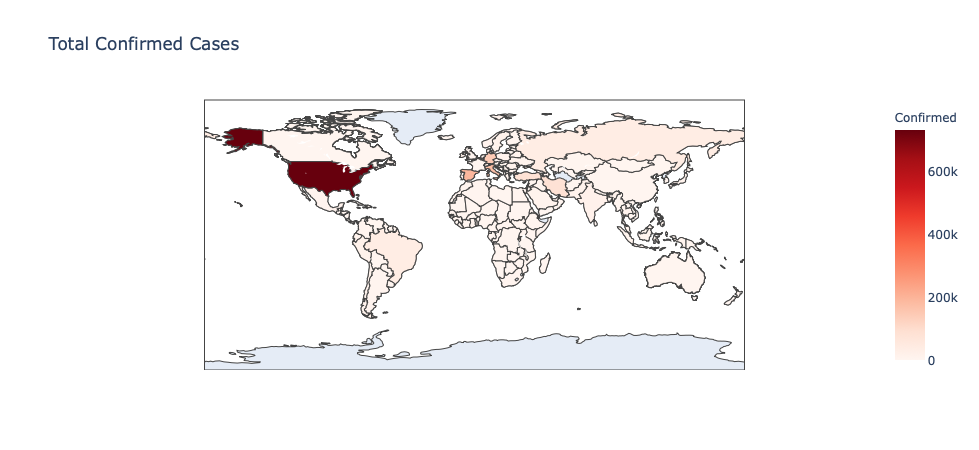

In [128]:
#fancy  visualization
fig_c = px.choropleth(data, locations="Country", locationmode='country names', 
                      color="Confirmed", hover_name="Country", 
                      hover_data=['Confirmed'],color_continuous_scale="Reds",
                      labels={'color':'Confirmed'},
                      title="Total Confirmed Cases")
fig_c.show()

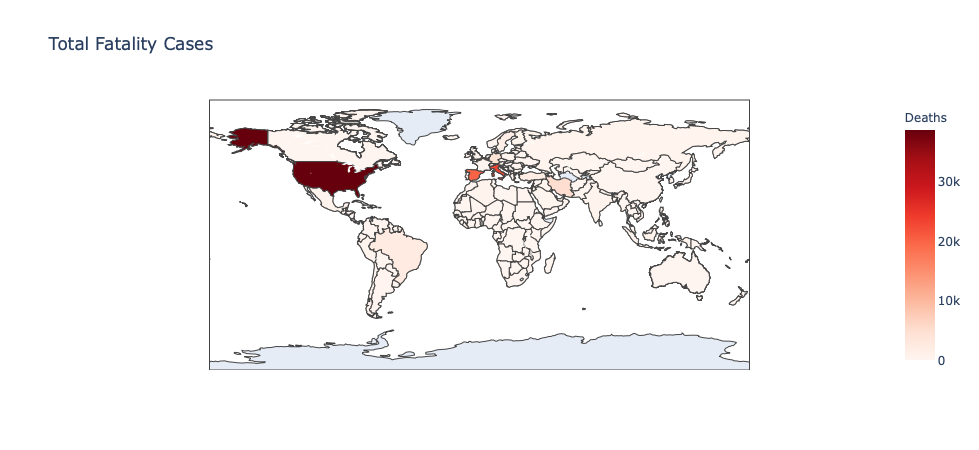

In [129]:
fig_d = px.choropleth(data, locations="Country", locationmode='country names', 
                      color="Deaths", hover_name="Country", 
                      hover_data=['Deaths'],color_continuous_scale="Reds",
                      labels={'color':'Deaths'},
                      title="Total Fatality Cases")
fig_d.show()

In [130]:
# clean data... For this job, we are only interested in saving the following columns: country, date, confirmation and death
conf = confirmed_tmp.drop(['Province/State','Lat','Long'],axis=1)
conf = conf.melt(id_vars=['Country/Region'], var_name = 'Date', value_name= 'Confirmed')
conf['date'] = pd.to_datetime(conf['Date'])
conf['date'] = conf['date'].dt.strftime('%Y/%m/%d')
conf=conf.drop('Date',axis=1)
conf_fig = conf.groupby(['date','Country/Region'])['Confirmed'].sum().reset_index()
print(conf)

death = death_tmp.drop(['Province/State','Lat','Long'],axis=1)
death = death.melt(id_vars=['Country/Region'], var_name = 'Date', value_name= 'Deaths')
death['date'] = pd.to_datetime(death['Date'])
death['date'] = death['date'].dt.strftime('%Y/%m/%d')
death =death.drop('Date',axis=1)
deaths_fig = death.groupby(['date','Country/Region'])['Deaths'].sum().reset_index()
print(death)

              Country/Region  Confirmed        date
0                Afghanistan          0  2020/01/22
1                    Albania          0  2020/01/22
2                    Algeria          0  2020/01/22
3                    Andorra          0  2020/01/22
4                     Angola          0  2020/01/22
...                      ...        ...         ...
23227                 France          1  2020/04/18
23228            South Sudan          4  2020/04/18
23229         Western Sahara          6  2020/04/18
23230  Sao Tome and Principe          4  2020/04/18
23231                  Yemen          1  2020/04/18

[23232 rows x 3 columns]
              Country/Region  Deaths        date
0                Afghanistan       0  2020/01/22
1                    Albania       0  2020/01/22
2                    Algeria       0  2020/01/22
3                    Andorra       0  2020/01/22
4                     Angola       0  2020/01/22
...                      ...     ...         ...
23227  

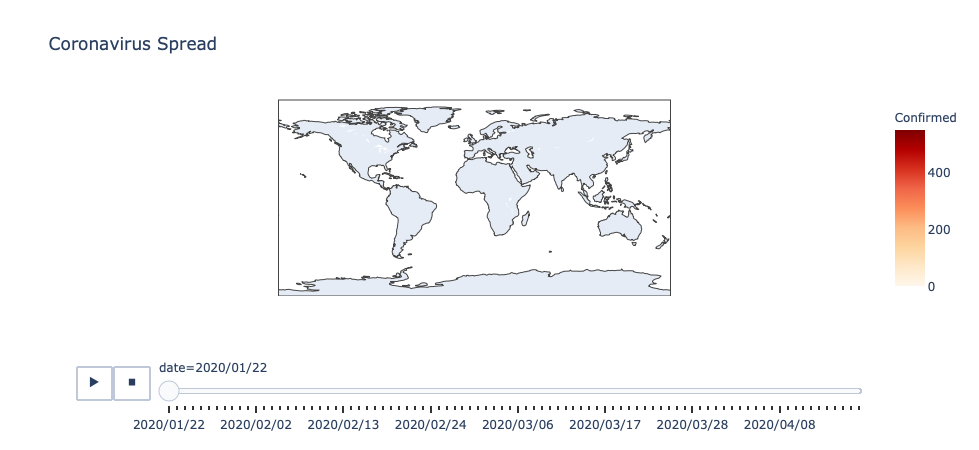

In [131]:
#Let's see how the disease has been spreading around the world
fig = px.scatter_geo(conf_fig.fillna(0), locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size="Confirmed", hover_name="Country/Region", 
                     projection="equirectangular", animation_frame="date", opacity = 0.7,
                     title='Coronavirus Spread',labels={'color':'Confirmed Cases'},color_continuous_scale="OrRd")
fig.update(layout_coloraxis_showscale=True)
fig.show()

In [243]:
#prepare the data for the ML 
all_cases = conf.copy()
all_cases['Deaths'] = death['Deaths']
#print(all_cases)
#print(all_cases.dtypes)
all_cases=all_cases.rename(columns={"Country/Region": "Country"}) 


LOG_TRANSFORM = False

def preprocess(
    df: pd.DataFrame,
    log_transform: bool = LOG_TRANSFORM
):
    
    # set index
    df = df.set_index('date')

   # df = df.fillna(0)
    
    df._get_numeric_data()[df._get_numeric_data() < 0] = 0
    assert df.isnull().sum().all() == 0
    
    # convert target values to log scale
    if log_transform:
        df[['Confirmed', 'Deaths']] = np.log1p(
            df[['Confirmed', 'Deaths']].values
    )
    
    return df

def split(
    df: pd.DataFrame, 
    date: str = '2020/04/13', 
):

    train = df.loc[df.index <= date] 
    test = df.loc[df.index > date]
    return train, test

all_cases = preprocess(all_cases)
train, test = split(all_cases)
print(f"{len(train)/len(all_cases.index) * 100}% in training set")
print(f"{len(test)/len(all_cases.index) * 100}% in testing set")
#print(all_cases)
#print(all_cases.dtypes)
#print(train)
#print(test)

94.31818181818183% in training set
5.681818181818182% in testing set


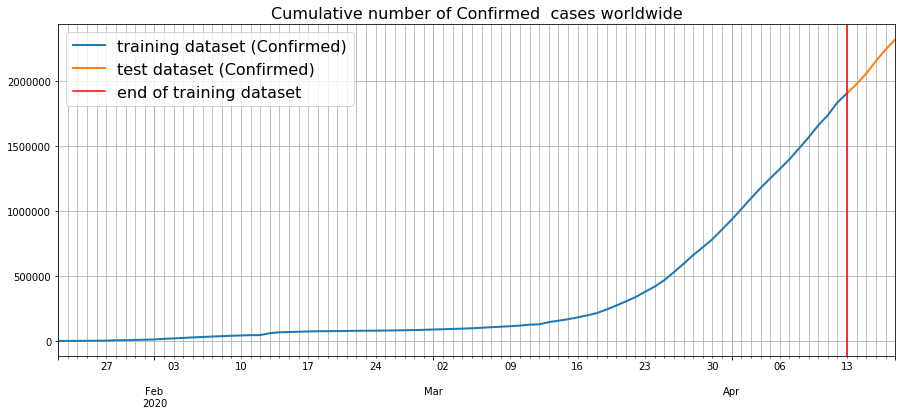

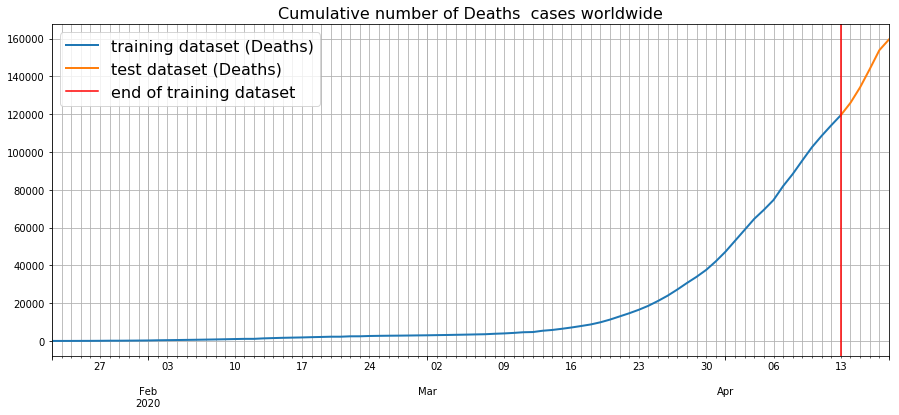

In [260]:
# plot confirmed cases and deaths in train data

def plot_observations(
    target: str = 'Confirmed',
    log_transform: bool = LOG_TRANSFORM
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')
    
    local_train = train.copy()
    local_test = test.copy()
    if log_transform:
        local_train[['Confirmed', 'Deaths']] = np.expm1(
            local_train[['Confirmed', 'Deaths']].values
        )
        local_test[['Confirmed', 'Deaths']] = np.expm1(
            local_test[['Confirmed', 'Deaths']].values
        )
    
    
    cum_train = local_train.groupby('date').sum()
    cum_test = local_test.groupby('date').sum()

    train_ds = ListDataset(
        [{"start": cum_train.index[0], "target": cum_train[target].values}],
        freq = "D",
    )
    test_ds = ListDataset(
        [{"start": cum_test.index[0], "target": cum_test[target].values}],
        freq = "D",
    )
    
    for tr, te in zip(train_ds, test_ds):
        tr = to_pandas(tr)
        te = to_pandas(te)
      #  te.plot(linewidth=2, label = f'test {target}')
        tr.plot(linewidth=2, label = f'training dataset ({target})')   
        tr[-1:].append(te).plot(linewidth=2, label = f'test dataset ({target})')
    
    plt.axvline(cum_train.index[-1], color='red', label = 'end of training dataset') 
    type_string = 'Cumulative' 
   
    plt.title(f'{type_string} number of {target}  cases worldwide', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(which="both")
    plt.show()
    
plot_observations('Confirmed')
plot_observations('Deaths')



In [245]:
# generate BERT embeddings

places = []
for idx,row in train.iterrows():
    places.append(row['Country'])
places = np.unique(places)
#print(places)
model = SentenceTransformer('bert-base-nli-mean-tokens')
#model = SentenceTransformer('roberta-base-nli-mean-tokens')
country_embeddings = model.encode(list(places))
embedding_dim = len(country_embeddings[0])

#country = [p.split(',')[0] if p!="Korea, South" else p for p in places] #error catching
country = [p.split(',')[1][1:] if (len(p.split(','))==2 and p!='Korea, South') else p for p in places]
embed_df = pd.DataFrame(
    np.concatenate(
        [
#            np.array(province_state).reshape(-1,1),
            np.array(country).reshape(-1,1),
            country_embeddings
        ]
        ,axis=1)
)
embed_df.columns=['Country']+list(range(embedding_dim))
#print(embed_df)

INFO:root:Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /Users/friverap/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /Users/friverap/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer

In [246]:

def join_with_embeddings(
    df: pd.DataFrame,
    embed_df: pd.DataFrame
):
    
    # join, delete merge columns
    new_df = df.reset_index().merge(
        embed_df,
        left_on = ['Country'],
        right_on = ['Country'],
        how = 'left'
    ).set_index('date')
    
    #make sure no NaN in dataframe
    assert new_df.isnull().sum().sum()==0
    return new_df

def encode(
    df: pd.DataFrame
):
    """ encode 'Country' categorical variables as numerical ordinals"""
    
    enc = OrdinalEncoder()
    df[['Country']] = enc.fit_transform(
        df[['Country']].values
    )
    return df, enc

join_df = join_with_embeddings(all_cases, embed_df)
#print(join_df)
all_df, enc = encode(join_df)
#print(all_df)
train_df, test_df = split(all_df)
#print(train_df)
#print(test_df)
_, val_df = split(all_df, date = '2020/03/20')

print(f"{len(train['Country'].unique())} countries")
#print(val_df)

185 countries


In [247]:
#for more details you can visit https://gluon-ts.mxnet.io/examples/index.html
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing

REAL_VARS = list(range(embedding_dim))

def build_dataset(
    frame: pd.DataFrame,
    target: str = 'Deaths',
    cat_vars: typing.List[str] = ['Country'],
    real_vars: typing.List[int] = REAL_VARS
):
    return ListDataset(
        [
            {
                FieldName.START: df.index[0], 
                FieldName.TARGET: df[target].values,
                FieldName.FEAT_STATIC_CAT: df[cat_vars].values[0],
                FieldName.FEAT_STATIC_REAL: df[real_vars].values[0]
            }
            for g, df in frame.groupby('Country')
        ],
        freq = "D",
    )

training_data_deaths = build_dataset(train_df)
training_data_cases = build_dataset(train_df, target = 'Confirmed')
training_data_deaths_all = build_dataset(all_df)
training_data_cases_all = build_dataset(all_df, target = 'Confirmed')
val_data_deaths = build_dataset(val_df)
val_data_cases = build_dataset(val_df, target = 'Confirmed')

In [254]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.distribution import NegativeBinomialOutput
import mxnet as mx
import numpy as np

# set random seeds for reproducibility
mx.random.seed(0)
np.random.seed(0)

def fit(
    training_data: ListDataset,
    validation_data: ListDataset = None,
    pred_length: int = 5,
    epochs: int = 60, 
    weight_decay: float = 5e-5,
    log_preds: bool = LOG_TRANSFORM,
):
    estimator = DeepAREstimator(
        freq="D", 
        prediction_length=pred_length,
        context_length=pred_length//2,
        use_feat_static_cat = True,
        use_feat_static_real = True,
        num_layers = 50,
        cardinality = [train['Country'].nunique()],
        distr_output=NegativeBinomialOutput(),
        trainer=Trainer(
            epochs=epochs,
            learning_rate=0.001,
            batch_size=64,
            weight_decay=weight_decay,
            learning_rate_decay_factor=0.1,
            patience=15
        ),
    )
    _, trained_net, predictor = estimator.train_model(
        training_data = training_data, 
        validation_data = validation_data
    )
    
    return predictor, trained_net

predictor_deaths, net = fit(training_data_deaths, val_data_deaths)
predictor_cases, case_net = fit(training_data_cases, val_data_cases)
predictor_death_all, all_net = fit(training_data_deaths_all, pred_length=20)
predictor_cases_all, all_case_net = fit(training_data_cases_all, pred_length=20)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
100%|██████████| 50/50 [00:17<00:00,  2.87it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[0] Elapsed time 17.441 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2.288528
0it [00:00, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
1it [00:00,  2.78it/s, validation_avg_epoch_loss=3.6]
INFO:root:Epoch[0] Elapsed time 0.363 seconds
INFO:root:Epoch[0] Evaluation metric 'validation_epoch_loss'=3.598898
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  2.98it/s, avg_epoch_loss=1.4] 
INFO:root:Epoch[1] Elapsed time 16.803 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.396495
1it [00:00,  2.70it/s, validation_avg_epoch_loss=3.35]
INFO:root:Epoch[1] Elapsed time 0.373 seconds
INFO:root:Epoch[1] Evaluation metric 'validation_epoch_loss'=3.351440
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  2.96it/s, avg_epoch_loss=1.26]
INFO:root:

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
100%|██████████| 50/50 [00:16<00:00,  3.00it/s, avg_epoch_loss=3.77]
INFO:root:Epoch[0] Elapsed time 16.649 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.767127
0it [00:00, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
2it [00:00,  5.08it/s, validation_avg_epoch_loss=12.6]
INFO:root:Epoch[0] Elapsed time 0.395 seconds
INFO:root:Epoch[0] Evaluation metric 'validation_epoch_loss'=12.647735
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.12it/s, avg_epoch_loss=3.52]
INFO:root:Epoch[1] Elapsed time 16.009 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.522583
1it [00:00,  2.83it/s, validation_avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 0.356 seconds
INFO:root:Epoch[1] Evaluation metric 'validation_epoch_loss'=7.820357
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.11it/s, avg_epoch_loss=3.28]
INFO:roo

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
100%|██████████| 50/50 [01:10<00:00,  1.42s/it, avg_epoch_loss=1.54]
INFO:root:Epoch[0] Elapsed time 70.959 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.535905
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [01:06<00:00,  1.33s/it, avg_epoch_loss=1.4] 
INFO:root:Epoch[1] Elapsed time 66.595 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.395657
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [01:06<00:00,  1.33s/it, avg_epoch_loss=1.25]
INFO:root:Epoch[2] Elapsed time 66.308 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.249884
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [01:06<00:00,  1.33s/it, avg_epoch_loss=1.14]
INFO:root:Epoch[3] Elapsed time 66.514 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.144971
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [01:06<00:00,  1.32s/it, avg_epoch_loss=1.05]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 795412
100%|██████████| 50/50 [01:10<00:00,  1.42s/it, avg_epoch_loss=4.05]
INFO:root:Epoch[0] Elapsed time 70.898 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.051536
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [01:06<00:00,  1.32s/it, avg_epoch_loss=3.57]
INFO:root:Epoch[1] Elapsed time 66.153 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.572791
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [01:05<00:00,  1.32s/it, avg_epoch_loss=3.34]
INFO:root:Epoch[2] Elapsed time 65.814 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.336717
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [01:05<00:00,  1.32s/it, avg_epoch_loss=3.23]
INFO:root:Epoch[3] Elapsed time 65.799 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.229269
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [01:05<00:00,  1.31s/it, avg_epoch_loss=3.12]

In [255]:
#Plot predictions from fit model parameters

def plot_prediction(
    predictor,
    train_df: pd.DataFrame,
    location: List[str] = ['Spain'],
    target: str = 'Deaths',
    cat_vars: typing.List[str] = ['Country'],
    real_vars: typing.List[int] = REAL_VARS,
    log_preds: bool = LOG_TRANSFORM,
    show_gt: bool = True,
    start_offset: int = 0, 
    fontsize: int = 16,
    save: bool = False
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    # plot train observations, true observations from public test set, and forecasts
    location_tr = enc.transform(np.array(location).reshape(1,-1))
    tr_df = train_df[np.all((train_df[['Country']].values == location_tr), axis=1)]

    train_obs = ListDataset(
        [{
            FieldName.START: tr_df.index[0], 
            FieldName.TARGET: tr_df[target].values,
            FieldName.FEAT_STATIC_REAL: tr_df[real_vars].values[0],
            FieldName.FEAT_STATIC_CAT: tr_df[cat_vars].values[0],
        }],
        freq = "D",
    )
    te_df = test_df[np.all((test_df[['Country']].values == location_tr), axis=1)]

    test_gt = ListDataset(
        [{"start": te_df.index[0], "target": te_df[target].values}],
        freq = "D",
    )

    for train_series, gt, forecast in zip(train_obs, test_gt, predictor.predict(train_obs)):
        
        train_series = to_pandas(train_series)
        gt = to_pandas(gt)
        
        if start_offset:
            train_series = train_series[start_offset:]
        
        
        # connect train series visually (either to GT or to forecast)
        if show_gt:
            train_series[train_series.index[-1] + pd.DateOffset(1)] = gt.iloc[0]
        else:
            train_series[train_series.index[-1] + pd.DateOffset(1)] = forecast.median[:1][0]
            
        # log transforms
        if log_preds:
            train_series = np.expm1(train_series)
            gt = np.expm1(gt)
            forecast.samples = np.expm1(forecast.samples) 
            forecast._sorted_samples_value = None
            
      #  print(train_series)

        # plot
        
        if show_gt:
            gt.plot(linewidth=2, label = 'Confirmed cases', color='r')
        
        train_series.plot(linewidth=2, label = 'train series')
        # plot layout
        type_date = '%Y-%b-%d %H:%M'
        type_string = 'Cumulative' 
        plt.title(
            f'{len(forecast.median)} predicted days: {type_string} number of {target} in {location[0]}. \n Last update: { str(datetime.datetime.now().strftime(type_date))} ', 
            fontsize=fontsize
        )
        plt.legend(fontsize = fontsize)
        plt.grid(which='both')
        
        if save:
            forecast.plot(
                color='g', 
                prediction_intervals=[50.0, 90.0], 
                show_mean = True,
                output_file = f'{len(forecast.median)} day forecast {type_string} number of {target} cases in {location[0]}'
            )
        else:
            prediction_intervals=[50.0, 90.0]
            if show_gt:
                legend = ["confirmed cases", "train series", "median prediction"] +[f"{k}% prediction interval" for k in prediction_intervals][::-1]
            else:
                legend = ["confirmed cases", "median prediction"] +[f"{k}% prediction interval" for k in prediction_intervals][::-1]
            forecast.plot(color='g', prediction_intervals = prediction_intervals, show_mean = False)
        forecast._sorted_samples_value = None
        plt.grid(which='both')
        plt.legend(legend, loc="upper left")
        plt.show()

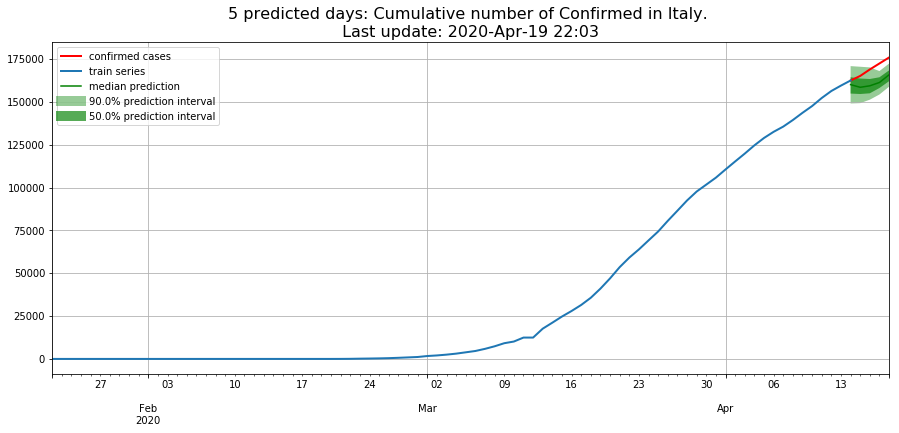

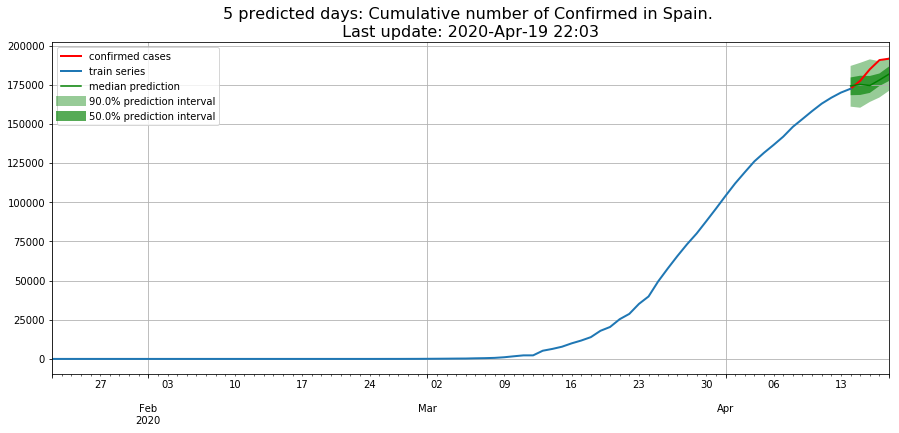

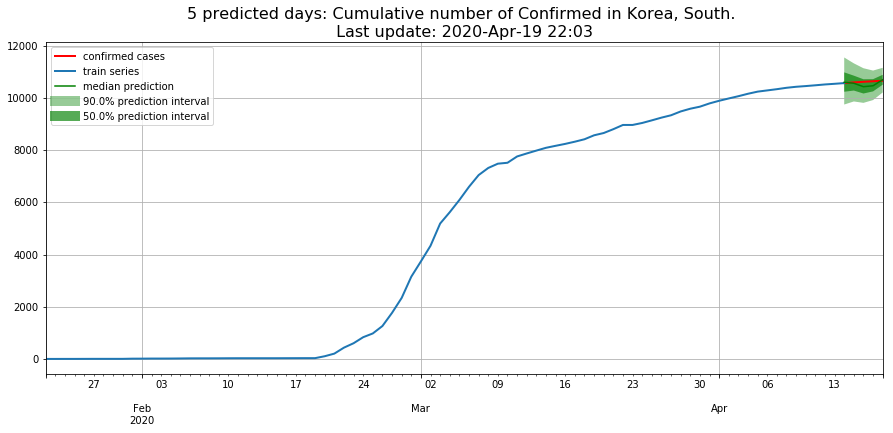

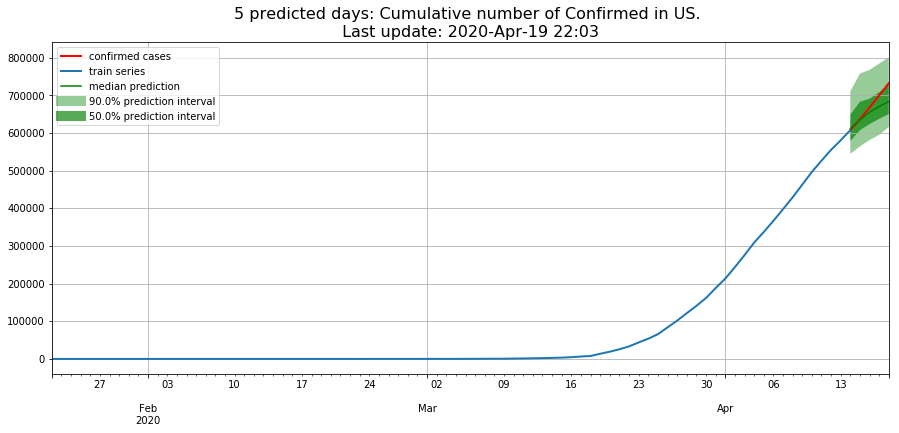

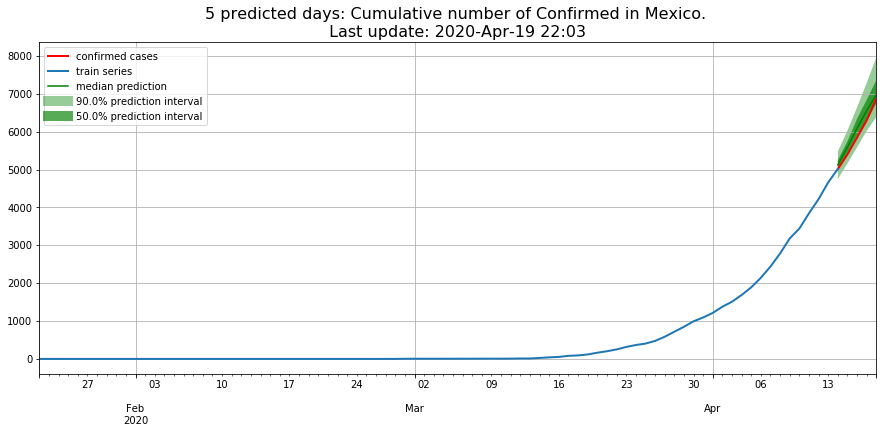

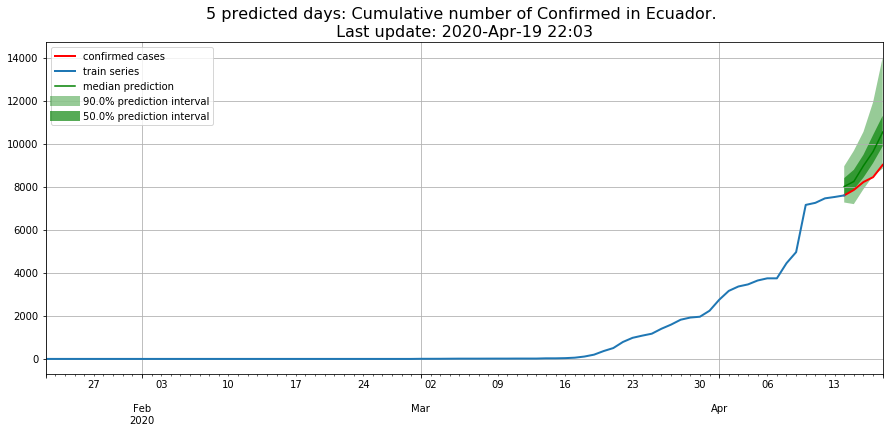

In [256]:
#plot public leaderboard case forecasts, Plot 8 day case forecasts (April 13th - April 18th)
plot_prediction(predictor_cases, train_df, ['Italy'],  target='Confirmed')
plot_prediction(predictor_cases, train_df, ['Spain'], target='Confirmed')
plot_prediction(predictor_cases, train_df, ['Korea, South'], target='Confirmed')
plot_prediction(predictor_cases, train_df, ['US'], target='Confirmed')
plot_prediction(predictor_cases, train_df, ['Mexico'], target='Confirmed')
plot_prediction(predictor_cases, train_df, ['Ecuador'], target='Confirmed')

In the figures above, we can see the prediction curve contrasted with the confirmed cases for several countries. In red we show the accumulated number of confirmed cases so far, the blue line is associated with the trained series, the light green and dark green shades represent the 90% and 50% confidence interval, respectively. Finally, the green line is the expected result.

We can see that the predictions are quite good. Of course, we need to quantify the error between the expected and confirmed cases for all countries ... We will do that later ...

Now, let's move on to a bigger forecast window. For this, we choose 20 days of prediction. It is important to say that for a forecast greater than 20 days, the neural network does not offer good predictions, that is, the error between the confirmed cases and the expected predictions does not tend to zero, at least with the parameters used in this notebook.


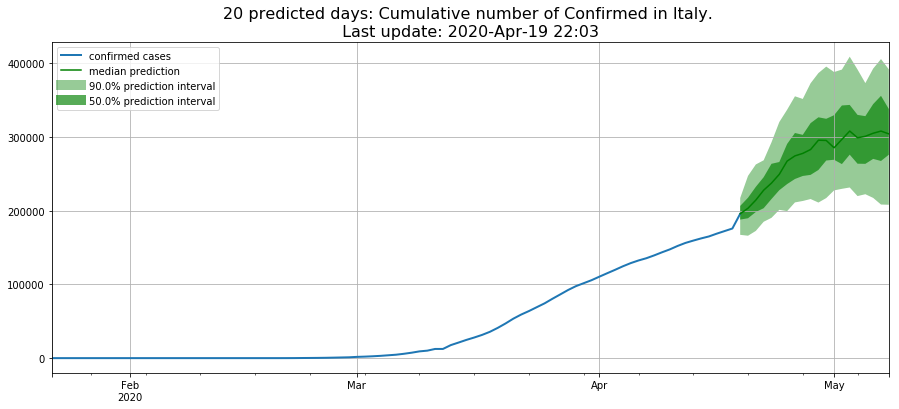

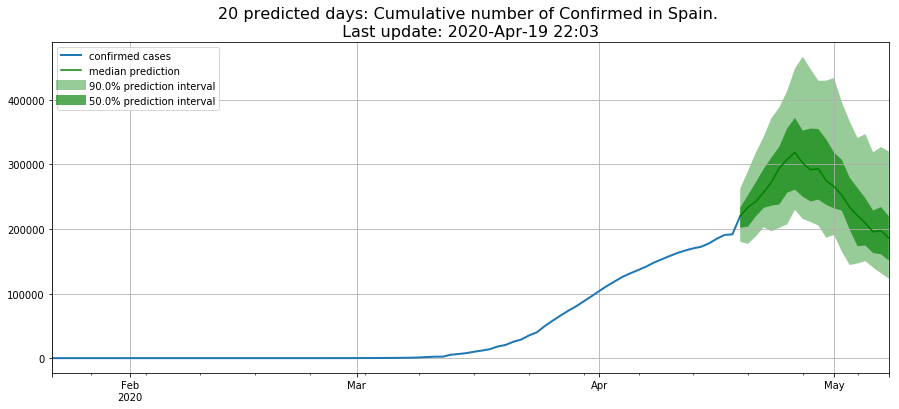

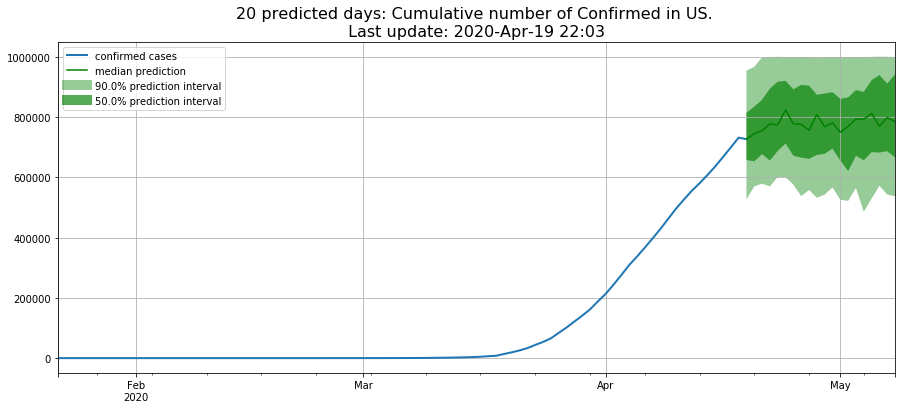

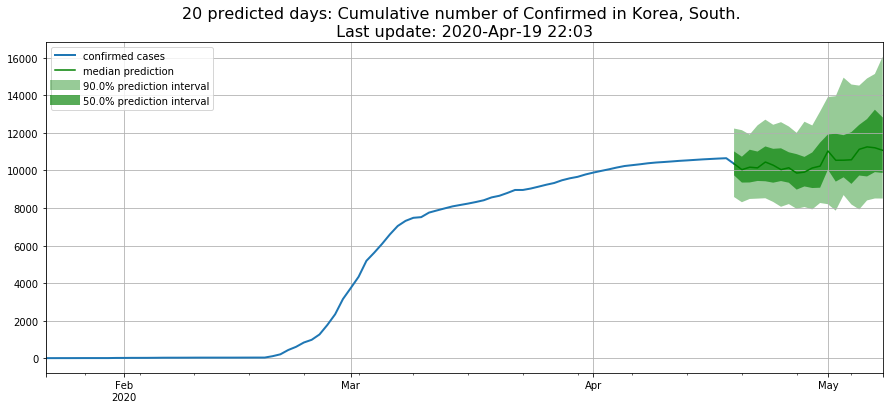

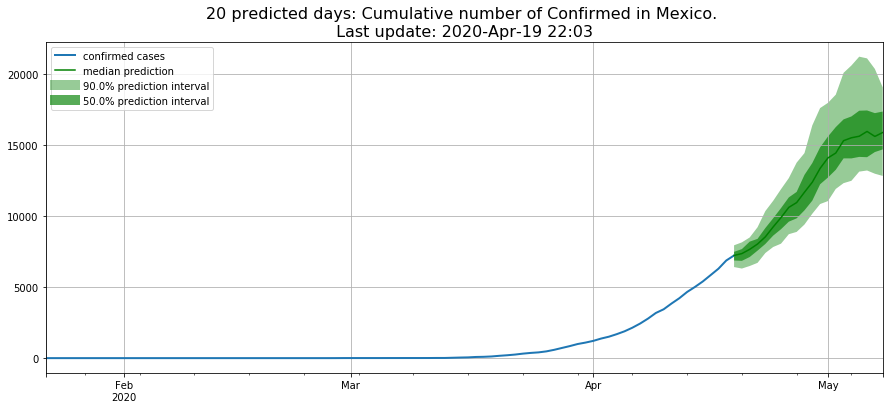

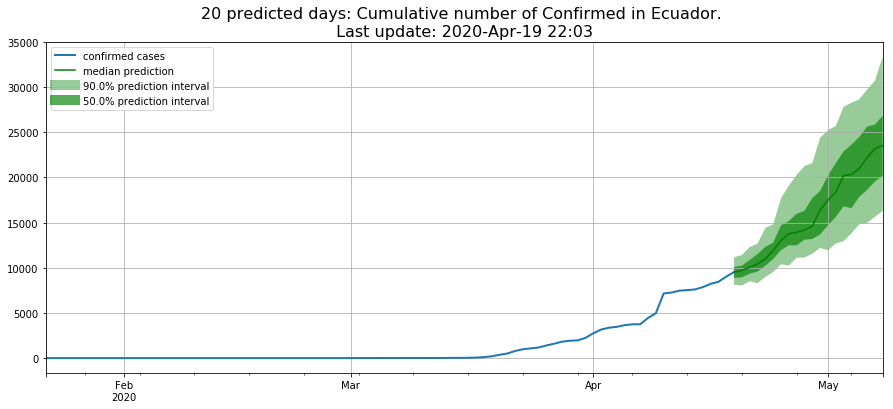

In [257]:
# plot private leaderboard case forecasts
plot_prediction(predictor_cases_all, all_df, ['Italy'], show_gt = False, target='Confirmed')
plot_prediction(predictor_cases_all, all_df, ['Spain'], show_gt = False, target='Confirmed')
plot_prediction(predictor_cases_all, all_df, ['US'], show_gt = False, target='Confirmed')
plot_prediction(predictor_cases_all, all_df, ['Korea, South'], show_gt = False, target='Confirmed')
plot_prediction(predictor_cases_all, all_df, ['Mexico'], show_gt = False, target='Confirmed')
plot_prediction(predictor_cases_all, all_df, ['Ecuador'], show_gt = False, target='Confirmed')

In [262]:
#To do. Calculate metrics on public test... 


## Last words

In this project, we used a recurrent autoregressive neural network (RNN) to produce some predictions of the coronavirus time [series](https://github.com/CSSEGISandData/COVID-19). The trained RNN can be used to produce a probabilistic forecast. This can provide a confidence interval that allows estimating the worst-, best-case scenario, and the expected scenario.

To be rigorus in the analysis, we need to 

* calutate the metrics per confirmed and death cases
* explore the RNN parameter space (epochs,learning_rate, etc.)


Beyond this little prediction exercise, we hope that all of this ends as soon as possible and, of course, in the best possible way. Be strong!... and stay at home...

Finally, to avoid this disease, we must follow the suggestion of health experts:

* Avoid contact with people who are sick.
* Avoid touching your eyes, nose, and mouth.
* Stay home when you are sick.
* Cover your cough or sneeze with a tissue, then throw the tissue in the trash.
* Clean and disinfect frequently touched objects and surfaces using a regular household
* Wash your hands often with soap and water, especially after going to the bathroom; before eating; and after blowing your nose, coughing, or sneezing. If soap and water are not readily available, use an alcohol-based hand sanitizer.